In [46]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import nasdaqdatalink
import matplotlib.pyplot as plt
import requests
import json
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
# from torch.utils.data import DataLoader


In [4]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_ETH_USD/history?period_id=1DAY&limit=10000'
headers = {'X-CoinAPI-Key' : '42D2F86D-F548-43D2-96C1-D7DB039EF63E'}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-10T00:00:00.0000000Z', 'time_period_end': '2023-09-11T00:00:00.0000000Z', 'time_open': '2023-09-10T00:00:12.4050000Z', 'time_close': '2023-09-10T03:44:52.1620000Z', 'price_open': 1635.6, 'price_high': 1635.6, 'price_low': 1627.5, 'price_close': 1631.2, 'volume_traded': 202.00461345, 'trades_count': 611}, {'time_period_start': '2023-09-09T00:00:00.0000000Z', 'time_period_end': '2023-09-10T00:00:00.0000000Z', 'time_open': '2023-09-09T00:00:01.0110000Z', 'time_close': '2023-09-09T23:58:29.6580000Z', 'price_open': 1636, 'price_high': 1637.3, 'price_low': 1629.7, 'price_close': 1635.3, 'volume_traded': 1588.74111545, 'trades_count': 5245}, {'time_period_start': '2023-09-08T00:00:00.0000000Z', 'time_period_end': '2023-09-09T00:00:00.0000000Z', 'time_open': '2023-09-08T00:00:05.8280000Z', 'time_close': '2023-09-08T23:59:25.6100000Z', 'price_open': 1647.8, 'price_high': 1658.1, 'price_low': 1616.1, 'price_close': 1636, 'volume_traded': 3926.05948046, 'trades_cou

In [6]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-10T00:00:00.0000000Z,2023-09-11T00:00:00.0000000Z,2023-09-10T00:00:12.4050000Z,2023-09-10T03:44:52.1620000Z,1635.6,1635.6,1627.5,1631.2,202.004613,611
1,2023-09-09T00:00:00.0000000Z,2023-09-10T00:00:00.0000000Z,2023-09-09T00:00:01.0110000Z,2023-09-09T23:58:29.6580000Z,1636.0,1637.3,1629.7,1635.3,1588.741115,5245
2,2023-09-08T00:00:00.0000000Z,2023-09-09T00:00:00.0000000Z,2023-09-08T00:00:05.8280000Z,2023-09-08T23:59:25.6100000Z,1647.8,1658.1,1616.1,1636.0,3926.059480,10596
3,2023-09-07T00:00:00.0000000Z,2023-09-08T00:00:00.0000000Z,2023-09-07T00:00:05.9800000Z,2023-09-07T23:59:45.6740000Z,1632.2,1658.1,1622.6,1647.9,5015.308811,8506
4,2023-09-06T00:00:00.0000000Z,2023-09-07T00:00:00.0000000Z,2023-09-06T00:00:24.4450000Z,2023-09-06T23:59:48.4300000Z,1634.0,1668.6,1608.8,1632.2,5221.802148,5166


In [7]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

In [8]:
#inspect df
data.head()

,time_period_start,price_close
0,2023-09-10T00:00:00.0000000Z,1631.2
1,2023-09-09T00:00:00.0000000Z,1635.3
2,2023-09-08T00:00:00.0000000Z,1636.0
3,2023-09-07T00:00:00.0000000Z,1647.9
4,2023-09-06T00:00:00.0000000Z,1632.2


In [9]:
#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

In [10]:
#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

In [11]:
data.head()

,Date,Close
0,2023-09-10,1631.2
1,2023-09-09,1635.3
2,2023-09-08,1636.0
3,2023-09-07,1647.9
4,2023-09-06,1632.2


In [12]:
#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

In [47]:
data.head()

,Date,Close
2202,2017-08-20,298.40
2201,2017-08-21,319.31
2200,2017-08-22,312.22
2199,2017-08-23,315.61
2198,2017-08-24,323.84


In [48]:
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device

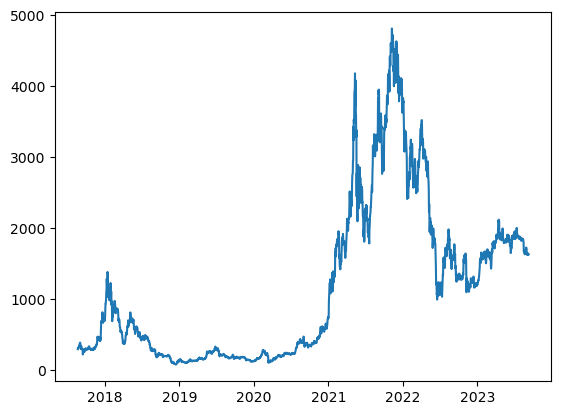

In [49]:
#plot historical eth price
plt.plot(data['Date'], data['Close'])

In [50]:
# build 1 week lookback for lstm training
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2017-08-27,347.55,332.38,329.00,323.84,315.61,312.22,319.31,298.40
2017-08-28,346.68,347.55,332.38,329.00,323.84,315.61,312.22,319.31
2017-08-29,372.37,346.68,347.55,332.38,329.00,323.84,315.61,312.22
2017-08-30,383.03,372.37,346.68,347.55,332.38,329.00,323.84,315.61
2017-08-31,388.00,383.03,372.37,346.68,347.55,332.38,329.00,323.84
...,...,...,...,...,...,...,...,...
2023-09-06,1632.20,1634.00,1629.70,1635.80,1637.10,1628.60,1645.60,1705.30
2023-09-07,1647.90,1632.20,1634.00,1629.70,1635.80,1637.10,1628.60,1645.60
2023-09-08,1636.00,1647.90,1632.20,1634.00,1629.70,1635.80,1637.10,1628.60


In [51]:
#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 347.55,  332.38,  329.  , ...,  312.22,  319.31,  298.4 ],
       [ 346.68,  347.55,  332.38, ...,  315.61,  312.22,  319.31],
       [ 372.37,  346.68,  347.55, ...,  323.84,  315.61,  312.22],
       ...,
       [1636.  , 1647.9 , 1632.2 , ..., 1635.8 , 1637.1 , 1628.6 ],
       [1635.3 , 1636.  , 1647.9 , ..., 1629.7 , 1635.8 , 1637.1 ],
       [1631.2 , 1635.3 , 1636.  , ..., 1634.  , 1629.7 , 1635.8 ]])

In [52]:
shifted_df_as_np.shape

(2196, 8)

In [53]:
#scale data with min/max scaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.88807024, -0.89448641, -0.89591599, ..., -0.9030131 ,
        -0.90001438, -0.90885829],
       [-0.88843821, -0.88807024, -0.89448641, ..., -0.9015793 ,
        -0.9030131 , -0.90001438],
       [-0.8775726 , -0.88843821, -0.88807024, ..., -0.89809841,
        -0.9015793 , -0.9030131 ],
       ...,
       [-0.34311901, -0.33808589, -0.34472622, ..., -0.3432036 ,
        -0.34265376, -0.34624885],
       [-0.34341508, -0.34311901, -0.33808589, ..., -0.3457836 ,
        -0.3432036 , -0.34265376],
       [-0.34514917, -0.34341508, -0.34311901, ..., -0.34396491,
        -0.3457836 , -0.3432036 ]])

In [54]:
#check shapes
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((2196, 7), (2196,))

In [55]:
#Flip columns from T-1 first to T-7 first)

X = dc(np.flip(X, axis=1))
X

array([[-0.90885829, -0.90001438, -0.9030131 , ..., -0.89809841,
        -0.89591599, -0.89448641],
       [-0.90001438, -0.9030131 , -0.9015793 , ..., -0.89591599,
        -0.89448641, -0.88807024],
       [-0.9030131 , -0.9015793 , -0.89809841, ..., -0.89448641,
        -0.88807024, -0.88843821],
       ...,
       [-0.34624885, -0.34265376, -0.3432036 , ..., -0.34396491,
        -0.34472622, -0.33808589],
       [-0.34265376, -0.3432036 , -0.3457836 , ..., -0.34472622,
        -0.33808589, -0.34311901],
       [-0.3432036 , -0.3457836 , -0.34396491, ..., -0.33808589,
        -0.34311901, -0.34341508]])

In [56]:
#set train vs test (95% train, 5% test)

split_index = int(len(X) * 0.95)

split_index

2086

In [57]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2086, 7), (110, 7), (2086,), (110,))

In [58]:
#extra dimension for pytorch

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2086, 7, 1), (110, 7, 1), (2086, 1), (110, 1))

In [59]:
#convert arrays to pytorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2086, 7, 1]),
 torch.Size([110, 7, 1]),
 torch.Size([2086, 1]),
 torch.Size([110, 1]))

In [60]:
#turn raw tensors into torch dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [61]:
train_dataset

In [62]:

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [63]:
# for _, batch in enumerate(train_loader):
#     x_batch, y_batch = batch[0].to(device), batch[1].to(device)
#     print(x_batch.shape, y_batch.shape)
#     break

In [64]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        
#         h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
# model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [77]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0], batch[1]
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [78]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0], batch[1]
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [79]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.006

Val Loss: 0.001
***************************************************

Epoch: 2
Batch 100, Loss: 0.004

Val Loss: 0.000
***************************************************

Epoch: 3
Batch 100, Loss: 0.003

Val Loss: 0.000
***************************************************

Epoch: 4
Batch 100, Loss: 0.003

Val Loss: 0.000
***************************************************

Epoch: 5
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 6
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 7
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 8
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 9
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 10
Batch 100, Loss: 0.002

Val Loss: 0.000
********************************

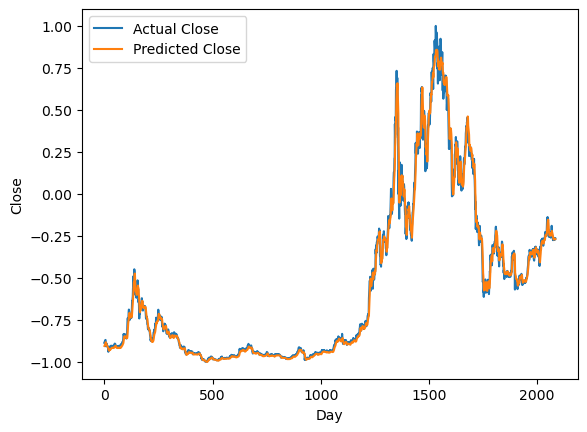

In [80]:
with torch.no_grad():
    predicted = model(X_train).numpy()
#     predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [81]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 304.69032587,  312.33018698,  317.39364543, ..., 1811.12600915,
       1814.66577952, 1810.50593631])

In [82]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 347.55004253,  346.67996759,  372.3700082 , ..., 1820.20000009,
       1805.39998877, 1817.69997914])

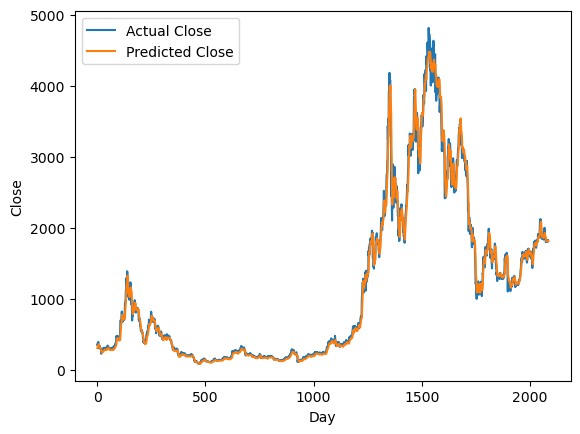

In [83]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [84]:
test_predictions = model(X_test).detach().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([1813.15392919, 1829.6737971 , 1816.65734075, 1812.29414183,
       1818.76615211, 1823.21996622, 1858.19831045, 1871.42072963,
       1882.59740168, 1878.4355855 , 1871.43249692, 1885.57671076,
       1887.16106733, 1886.83792482, 1853.8405724 , 1865.75382756,
       1850.55038134, 1847.80472699, 1843.3406253 , 1804.59128695,
       1783.08251026, 1766.26134332, 1754.43852719, 1711.53047302,
       1692.70280674, 1702.72219738, 1713.06007998, 1716.61774791,
       1725.78580673, 1754.05760517, 1810.90306478, 1836.4107476 ,
       1860.26653523, 1867.02934558, 1881.0619463 , 1872.00035681,
       1879.12217525, 1866.36565625, 1892.97530716, 1903.76866145,
       1916.03736632, 1930.66333448, 1931.51128409, 1921.18671896,
       1889.58308594, 1880.45061085, 1872.38719771, 1866.70289132,
       1870.41240664, 1871.84005389, 1870.18424802, 1924.73642459,
       1927.84651267, 1927.94924746, 1924.91187702, 1917.91858277,
       1908.11043967, 1898.57759482, 1893.11926271, 1890.61445

In [85]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([1854.50003396, 1799.99999987, 1805.99997971, 1828.60001414,
       1830.99997789, 1909.29999305, 1893.59999532, 1901.29999645,
       1873.99998603, 1862.40000858, 1907.19998954, 1892.70000891,
       1890.6000054 , 1810.69999092, 1884.50000359, 1832.80002116,
       1846.20000666, 1840.59997381, 1752.50002447, 1753.39997564,
       1742.69998459, 1739.39999921, 1651.00001917, 1665.19996909,
       1717.00000873, 1727.10000884, 1720.4999676 , 1736.7999915 ,
       1792.40002072, 1889.80000574, 1872.59999544, 1893.7000173 ,
       1876.20001152, 1899.90000585, 1859.39998343, 1890.00001446,
       1852.09999975, 1933.29998285, 1924.39999984, 1937.60001185,
       1956.00000403, 1936.69999021, 1910.39998818, 1847.60003249,
       1870.79998739, 1865.49998524, 1863.50000371, 1880.70001401,
       1878.69999725, 1871.70000903, 2004.79998328, 1938.9000157 ,
       1931.50001004, 1923.60000018, 1911.39999656, 1897.70001559,
       1888.70001061, 1891.49999181, 1891.999996  , 1866.40000

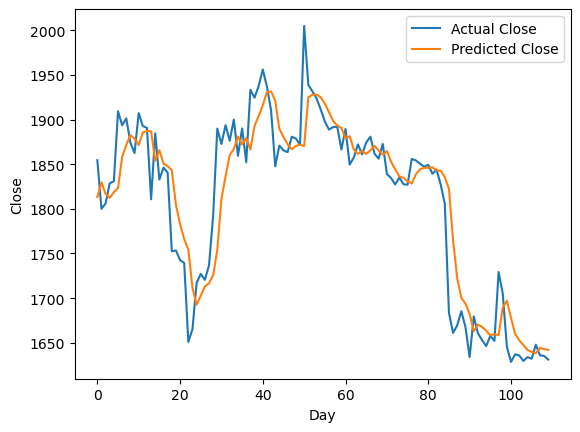

In [86]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [3]:
mydata = nasdaqdatalink.get("FRED/GDP", start_date="2001-12-31", end_date="2005-12-31")

In [4]:
print(mydata)

                Value
Date                 
2002-01-01  10783.500
2002-04-01  10887.460
2002-07-01  10984.040
2002-10-01  11061.433
2003-01-01  11174.129
2003-04-01  11312.766
2003-07-01  11566.669
2003-10-01  11772.234
2004-01-01  11923.447
2004-04-01  12112.815
2004-07-01  12305.307
2004-10-01  12527.214
2005-01-01  12767.286
2005-04-01  12922.656
2005-07-01  13142.642
2005-10-01  13324.204


In [21]:
mydata = nasdaqdatalink.get(["WIKI/TSLA.11"])

In [22]:
print(mydata)

            WIKI/TSLA - Adj. Close
Date                              
2010-06-29                   23.89
2010-06-30                   23.83
2010-07-01                   21.96
2010-07-02                   19.20
2010-07-06                   16.11
...                            ...
2018-03-21                  316.53
2018-03-22                  309.10
2018-03-23                  301.54
2018-03-26                  304.18
2018-03-27                  279.18

[1949 rows x 1 columns]


In [15]:
import requests

In [16]:
# https://gist.github.com/bruhbruhroblox/dd9d981c8c37983f61e423a45085e063


def get_ticker(company_name):
    yfinance = "https://query2.finance.yahoo.com/v1/finance/search"
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
    params = {"q": company_name, "quotes_count": 1, "country": "United States"}

    res = requests.get(url=yfinance, params=params, headers={'User-Agent': user_agent})
    data = res.json()

    company_code = data['quotes'][0]['symbol']
    return company_code

In [24]:
stock = get_ticker("Apple")

print(stock)

AAPL


In [63]:
call = f'["WIKI/{stock}"]'

In [64]:
print(call)

["WIKI/AAPL"]


In [65]:
mydata = nasdaqdatalink.get(call)

NotFoundError: (Status 400) (Nasdaq Data Link Error QECx01) We could not recognize the URL you requested: /api/v3/datasets/["WIKI/AAPL"]/data. Please check your URL and try again.

In [57]:
print(mydata)

            WIKI/AAPL - Adj. Close
Date                              
1980-12-12                0.422706
1980-12-15                0.400652
1980-12-16                0.371246
1980-12-17                0.380362
1980-12-18                0.391536
...                            ...
2018-03-21              171.270000
2018-03-22              168.845000
2018-03-23              164.940000
2018-03-26              172.770000
2018-03-27              168.340000

[9400 rows x 1 columns]
